In [1]:
# Fix py2
from __future__ import print_function, division

In [2]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load data from Jorge
dat_path = '/Users/thomasdonoghue/Desktop/'
dat = np.load(os.path.join(dat_path, 'data-for-tom.npy')).item()

In [4]:
# Get freqs, drop 0, & unembed freqs from being an array of arrays
freqs = dat['f'][1:]
freqs = [f[0] for f in freqs]

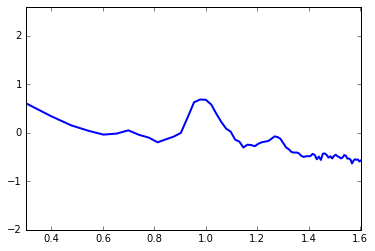

In [22]:
# Check plot - single PSD
plt_psd_1(freqs, dat[0][0]['eyesc'][1:])

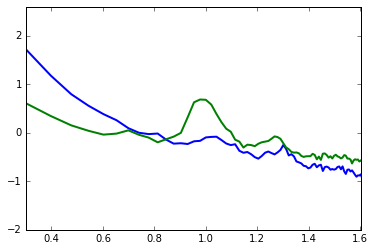

In [54]:
# Compare eyes open / eyes closed: single subject, single channel
plt_psd_2(freqs, dat[0][0]['eyeso'][1:], freqs, dat[0][0]['eyesc'][1:])

## FOOFing Data

In [41]:
# Import FOOF (use sys to add location to path, then import)
import sys
sys.path.append('/Users/thomasdonoghue/Documents/GitCode/')
from foof.fit import FOOF

In [42]:
# Set a PSD to run with FOOF
psd = dat[0][0]['eyesc'][1:]
psd_ext, freqs_ext = extract_psd(psd, freqs, 3, 40)

In [43]:
# Setting for FOOF
min_p = 0.2
freq_res = np.mean(np.diff(freqs))

In [115]:
# Initialize FOOF, fit PSD, and extract fit data
foof = FOOF(min_p=min_p, res=freq_res, fmin=freqs_ext.min(), fmax=freqs_ext.max())
foof.model(freqs_ext, psd_ext)
foof_dat = (foof.chi_, foof.centers_, foof.powers_, foof.stdevs_)
sl_foof = -foof.chi_

In [47]:
foof_dat

(0.61830951569805426,
 array([ 10.35524415,  18.39890162]),
 array([ 3.82048559,  0.84301203], dtype=float32),
 array([ 1.27399355,  1.27399355]))

## Checking FOOF PSD Fit

In [48]:
from foof import syn

In [49]:
fs, foof_model = syn.mfonef(
    mf=foof.centers_,
    mf_sig=foof.stdevs_,
    mk=foof.powers_,
    chi=foof.chi_,
    f0=freqs_ext.min(),
    fmax=freqs_ext.max(),
    res=freq_res,
    noi=0
)

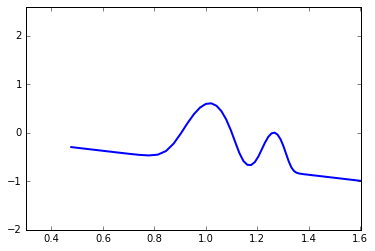

In [50]:
plt_psd_1(fs, foof_model)

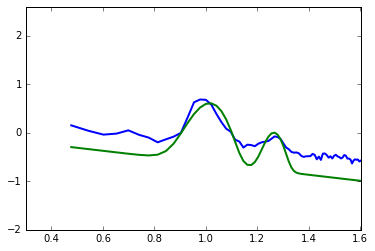

In [56]:
plt_psd_2(freqs_ext, psd_ext, fs, foof_model)

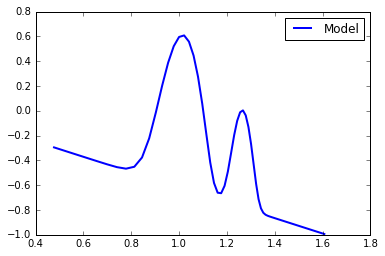

In [58]:
plt.plot(np.log10(fs), np.log10(foof_model), 'b', lw=2, label='Model')
#plt.plot(np.log10(freqs_ext), np.log10(psd_ext), 'g', lw=2, label='Data')
plt.legend()

## Check Robust Slope Fitting on PSDs

In [59]:
import statsmodels.api as sm

In [60]:
# Add constant for fitting with statsmodels
fx = sm.add_constant(np.log10(freqs_ext))

In [62]:
# Fit slope - robust linear fit to log-log PSD
fit_rlm = sm.RLM(np.log10(psd_ext), fx).fit()
sl_rlm = fit_rlm.params[1]

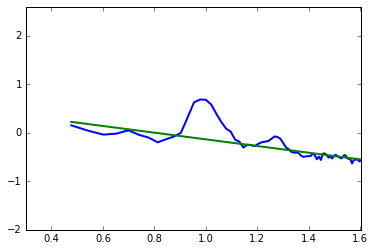

In [74]:
# Check the robust linear slope fit
plt_psd_2(freqs_ext, psd_ext, freqs_ext, np.power(10, sl_rlm.fittedvalues), log_f=True)

## RLM Slope Fitting Excluding Generic Alpha Band

In [157]:
# Exclude predefined alpha range
psd_alph, freqs_alph = exclude_psd(psd_ext, freqs_ext, [7, 14])

In [159]:
# Robust fit slope without alpha range
fx = sm.add_constant(np.log10(freqs_alph))
fit_rlm_alph = sm.RLM(np.log10(psd_alph), fx).fit()
sl_rlm_alph = fit_rlm_alph.params[1]

## RLM Slope Fitting Excluding Oscillatory Bands

In [112]:
# Foof dat is [slope_val, [centers], [powers], [bandwidths]]
foof_dat

(0.61830951569805426,
 array([ 10.35524415,  18.39890162]),
 array([ 3.82048559,  0.84301203], dtype=float32),
 array([ 1.27399355,  1.27399355]))

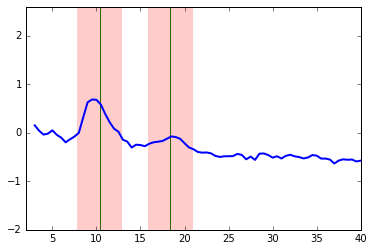

In [175]:
m = 2.0
log_f = False

plt_psd_1(freqs_ext, psd_ext, log_f=log_f)

for cen, bw in zip(foof_dat[1], foof_dat[3]):
    if log_f:
        cen = np.log10(cen)
        bw = np.log10(bw)
        plt.axvspan(cen, cen, color='g')
        plt.axvspan(cen-(m*bw), cen+(m*bw), color='r', alpha=0.2, lw=0)
    else:
        plt.axvspan(cen, cen, color='g')
        plt.axvspan(cen-(m*bw), cen+(m*bw), color='r', alpha=0.2, lw=0)

In [171]:
# Exclude FOOF oscillation bands
psd_excl = psd_ext
freqs_excl = freqs_ext
for cen, bw in zip(foof_dat[1], foof_dat[3]):
    psd_excl, freqs_excl = exclude_psd(psd_excl, freqs_excl, [cen-2*bw, cen+2*bw])

In [172]:
# Robust fit slope without FOOF oscillation bands
fx = sm.add_constant(np.log10(freqs_excl))
fit_rlm_excl = sm.RLM(np.log10(psd_excl), fx).fit()
sl_rlm_excl = fit_rlm_excl.params[1]

## Compare Slope Fits

In [176]:
print('FOOF: \t\t\t', sl_foof)
print('RLM: \t\t\t', sl_rlm)
print('RLM-Exclude Alpha:\t', sl_rlm_alph)
print('RLM-Exclude Oscs:\t', sl_rlm_excl)

FOOF: 			 -0.618309515698
RLM: 			 -0.688924899303
RLM-Exclude Alpha:	 -0.608192053132
RLM-Exclude Oscs:	 -0.601844962611


## Functions

In [72]:
# Plotting funcs - for convenience
def plt_psd_1(freqs, dat, log_f=True, log_p=True, label=None):
    
    min_f = 2; max_f = 40
    min_p = 0.01; max_p = 400
    
    if log_f:
        freqs = np.log10(freqs)
        min_f = np.log10(min_f)
        max_f = np.log10(max_f)
    
    if log_p:
        dat = np.log10(dat)
        min_p = np.log10(min_p)
        max_p = np.log10(max_p)
    
    plt.plot(freqs, dat, lw=2)
    
    plt.xlim([min_f, max_f])
    plt.ylim([min_p, max_p])
    
def plt_psd_2(freqs_1, dat_1, freqs_2, dat_2, log_f=True, log_p=True):
    
    plt.figure()
    plt_psd_1(freqs_1, dat_1, log_f, log_p)
    plt.hold(True)
    plt_psd_1(freqs_2, dat_2, log_f, log_p)
    plt.hold(False)

In [29]:
def extract_psd(psd, freqs, f_low, f_high):
    """Extract frequency range of interest from PSD data."""
    
    # Boolean indexing needs to be array - not list
    if isinstance(freqs, list):
        freqs = np.array(freqs)

    # Drop frequencies below f_low
    f_low_mask = freqs >= f_low
    freqs_ext = freqs[f_low_mask]
    psd_ext = psd[f_low_mask]

    # Drop frequencies above f_high
    f_high_mask = freqs_ext <= f_high
    freqs_ext = freqs_ext[f_high_mask]
    psd_ext = psd_ext[f_high_mask]
    
    # Reshape PSD for foof specs
    psd_ext = np.reshape(psd_ext, [len(freqs_ext), 1])

    return psd_ext, freqs_ext

In [153]:
def exclude_psd(psd, freqs, exclude):
    """Drop an exclusion range of frequencies."""
    
    f_mask = np.array([(a or b) for a, b in zip(freqs < exclude[0],
                                                freqs > exclude[1])])
    
    freqs_out = freqs[f_mask]
    psd_out = psd[f_mask]
    
    return psd_out, freqs_out